# Problème 1 (1h30)

Dans ce problème, on étudie la situation suivante. On dispose dans une zone donnée de deux cents capteurs ponctuels fixes. Ces capteurs échantillonnent parfaitement un champ scalaire 2D stationnaire qu'on va chercher à reconstruire. Mais il y a un obstacle : sur les deux cents capteurs disponibles, cent sont mal positionnés. Précisément, on connaît parfaitement la position des cents premiers capteurs à disposition (dans l'ordre des identifiants), mais la positions des cents suivants est inconnue (on sait seulement qu'ils n'occupent pas les "bords" du champ 2D).

La figure qui est générée trois cellules plus bas résume la situation (Onglet visualisation). On y voit une figure en noir et blanc simulaire aux champs 2D à reconstruire, des capteurs bien positionnés (croix bleues), ainsi que des capteurs mal positionnés (points rouges).

Le but du problème est de parvenir à trouver la position de tous les capteurs tout en reconstruisant le champ (pour rester raisonnable, nous nous conterons d'essayer de déterminer ces positions à une distance de cinq pixels maximum, sur les 64x64 que comporteront les images de travail). Il faut bien comprendre que les champs échantillonnées (clef "discs_gt" dans le batch) ne devront pas être utilisés autrement que pour mesurer des scores. Néanmoins, on supposera qu'il existe une base d'exemples de champs 2D de la même nature que ceux qu'on cherche à échantillonner (clef "discs_gan").



Dans la première partie, nous mettons en oeuvre une première méthode, relativement simple.
Dans la seconde partie, il s'agira d'implémenter un GAN en vue d'exploiter les champs 2D supplémentaires.
Dans la troisième partie, vous êtes invité à combiner les deux et à comparer.

# Imports et fonctions utiles



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import IterableDataset
import numpy as np
import math
from random import randint
import matplotlib.pyplot as plt
from torch.nn.utils import spectral_norm
#############################################################
#pour la génération des images    ###########################
#############################################################

def simu_rec(image, L,l,  fields=0):
    channels,size,size2=image.size()
    rec= torch.zeros(channels,size,size2)
    #out = 0*(image.clone())
    vertical=np.random.binomial(1,0.5)==1
    if vertical:
        width=l
        height=L
    else:
        width=L
        height=l

    top=randint(0, size-height)
    left=randint(0, size-width)
    rec[fields,top:top+height,left:left+width]=  np.random.uniform(0,0.4)   #0.1
    image=image + rec
    return image

def simu_noisy_rec(image, L,l,  fields=0):
    channels,size,size2=image.size()
    rec= torch.zeros(channels,size,size2)
    #out = 0*(image.clone())
    vertical=np.random.binomial(1,0.5)==1
    if vertical:
        width=l
        height=L
    else:
        width=L
        height=l

    top=randint(0, size-height)
    left=randint(0, size-width)
    rec[fields,top:top+height,left:left+width]= np.random.uniform(0,0.4)  #0.1
    noise=torch.randn(channels,size,size2)
    noise=noise*(noise>0).float()
    rec=noise*rec
    image=image + rec
    return image

def simu_disc(image, f, radius=15, fields=0 ):  #radial decrease function  #or 12
    channels,size,size2=image.size()
    center=np.array([randint(-radius, size+radius) , randint(-radius, size+radius) ])
    npdisc= f( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
    npdisc=np.random.uniform(0.6,1.) * npdisc  #variation on intensity
    image[fields,:,:] = image[fields,:,:] + torch.from_numpy(npdisc).float()   #matrice des distances < rayon
    return image

def simu_disc_with_cond(image, f, radius=15, fields=0, f2 = lambda a,x  : ((np.sin(3.1 * a/x**2)))*(a < x**2) ):  #radial decrease function  #or 12
    channels,size,size2=image.size()
    center=np.array([randint(radius-5, size-radius+2) , randint(radius-2, size-radius+5) ])
    npdisc= f( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
    npdisc=np.random.uniform(0.6,1.) * npdisc  #variation on intensity
    image[0,:,:] = image[0,:,:] + torch.from_numpy(npdisc).float()   #matrice des distances < rayon
    if (radius >= 10) and (radius <= 14):
        npdon = f2( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
        image[1,:,:] = image[1,:,:] + torch.from_numpy(npdon).float()**2
    return image


def simu_square(image, f, diag=15, fields=0 ):  #radial decrease function  #or 12
    channels,size,size2 = image.size()
    center=np.array([randint(diag, size-diag) , randint(diag, size-diag) ])

    npsquare = f(  np.abs(np.arange(0,64)*np.ones([size,size]) - center[0]) + \
                   np.abs(np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1]), diag)
#    npsquare = np.abs(np.arange(0,64)*np.ones([size,size]) - center[0])
    npsquare = np.random.uniform(0.6,1.) * npsquare  #variation on intensity
    image[fields,:,:] = image[fields,:,:] + torch.from_numpy(npsquare).float()   #matrice des distances < rayon
    return image


def plot_pairs(image, f = lambda x : x**2):
    horizontal = (torch.randint(0,2,(1,)) > 0.5).item()
#    print(horizontal)
    dist = torch.randint(1,32, (1,)).item()
    if horizontal :
        ordo = torch.randint(0, 64, (1,)).item()
        absi = torch.randint(0, 64 - dist, (1,)).item()
        image[1, ordo, absi:(absi + dist + 1)] \
            += 0.1 + torch.mean(f(image[0, ordo, absi:(absi + dist + 1)]))
    else :
        ordo = torch.randint(0, 64 - dist, (1,)).item()
        absi = torch.randint(0, 64, (1,)).item()
        image[1, ordo:ordo+dist+1, absi] \
            += 0.1 + torch.mean(f(image[0, ordo:ordo+dist+1, absi]))
    return image


def generate_noise(image, lambda_rec=0.001 ,lambda_noisy_rec = 0.001, lambda_disc = 0.001, lambda_square = 0., pola=[0,0.5,0.1]):
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(5,32)
        image=simu_disc(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2) ,radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)

    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image= simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    if pola[0]==1:      #add a pseudo pola field
        image_pola = generate_pola(image,pola)
        image=torch.cat([image,image_pola],dim=0)
    return image


def generate_noise_with_cond(image, lambda_rec=0.001 ,lambda_noisy_rec = 0.001, lambda_disc = 0.001, lambda_square = 0., pola=[0,0.5,0.1]):
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(6,18)
        image=simu_disc_with_cond(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2) ,radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)

    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image= simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    return image


def generate_noise_and_pairs(image, lambda_pairs = 0.01, lambda_rec=0.001 ,lambda_noisy_rec = 0.001, lambda_disc = 0.001, lambda_square = 0., pola=[0,0.5,0.1]):
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(5,10)
        image=simu_disc(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2) ,radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)

    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image = simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    # on ajoute le deuxième canal où les échanges entre signaux seront
    # représentés

    image2 = torch.zeros([1,64, 64])
    image = torch.cat([image,image2], dim = 0 )

    for j in range(np.random.poisson(lambda_pairs*64*64)):

        image = plot_pairs(image)

    return image


def make_image(rec, noisy_rec ,disc,square=0., pola=[0]):
    image=torch.zeros([1,64, 64])
    image = generate_noise(image, lambda_rec=rec, lambda_noisy_rec = noisy_rec,lambda_disc = disc, lambda_square = square, pola= pola)
    return image

def make_image_with_cond(rec, noisy_rec ,disc,square=0., pola=[0]):
    image = torch.zeros([2, 64, 64])
    image = generate_noise_with_cond(image, lambda_rec=rec, lambda_noisy_rec = noisy_rec,lambda_disc = disc, lambda_square = square, pola= pola)
    return image

def make_batch(batch_size, rec, noisy_rec ,disc, square=0., pola=[0] ):
    out = make_image(rec, noisy_rec ,disc , square, pola ).unsqueeze(0)
    for i in range(batch_size-1):
        new=make_image(rec, noisy_rec ,disc, square, pola).unsqueeze(0)
        out=torch.cat((out,new), dim=0)
    return out

def make_batch_with_cond(batch_size, rec, noisy_rec ,disc, square=0.):
    out = make_image_with_cond(rec, noisy_rec ,disc , square).unsqueeze(0)
    for i in range(batch_size-1):
        new=make_image_with_cond(rec, noisy_rec ,disc, square).unsqueeze(0)
        out=torch.cat((out,new), dim=0)
    return out

def make_image_with_pairs(rec, freq_integrated_signals, noisy_rec ,disc,square=0., pola=[0]):
    image=torch.zeros([1,64, 64])
    image = generate_noise_and_pairs(image, lambda_pairs = freq_integrated_signals, lambda_rec=rec, lambda_noisy_rec = noisy_rec,lambda_disc = disc, lambda_square = square, pola= pola)
    return image

def make_batch_with_pairs(batch_size, freq_integrated_signals, rec, noisy_rec, disc, square=0., pola=[0] ):
    out=make_image_with_pairs(rec, freq_integrated_signals, noisy_rec ,disc , square, pola ).unsqueeze(0)
    for i in range(batch_size - 1):
        new=make_image_with_pairs(rec, freq_integrated_signals, noisy_rec, disc, square, pola).unsqueeze(0)
        out=torch.cat((out,new), dim = 0)
    return out

def gen(n):  #exercice 1 partie 1
  target = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.002)
  noise =  make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.)
  return  target + noise, target     #bruit additif trivial

def gen_noise2noise(n):
  target = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.002)
  noise1 =  make_batch(n, rec = 0.0005, noisy_rec= 0.0005, disc = 0.)
  noise2 =  make_batch(n, rec = 0.0005, noisy_rec= 0.0005, disc = 0.)
  return  target + noise1, target + noise2

def gen1_NES(n):
  noisy_image = make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.002)
  return  noisy_image

def gen2_NES(n):
  noise1 =  make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.)
  return  noise1


def gen_proba(n):
  target1 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  m1 = torch.normal(target1**2, 0.2*target1)
  input = target1
  target =   m1
  return  input, target

def gen_ponct(n, p = 0.01):
  input = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  fulltarget = 2*input**2
  sb = torch.bernoulli(0*fulltarget + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle

  #cible fragmentaire
  target = fulltarget*(sb) + (-1)*(1 - sb)

  return  input, target, fulltarget


def gen_condDCGAN(n, p = 0.01):
  x = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001, square = 0.)
  fulltarget = x #2*x**2
#  sb = (make_batch(n, rec = 0., noisy_rec= 0., disc = p, square = 0.)> 0.1
  sb = torch.bernoulli(0*fulltarget + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
  #cond (ex. cible fragmentaire)
  y = fulltarget*sb + (-0.1)*(1 - sb)

  z = torch.randn(*fulltarget.size())
  return  x, y, z


def get_discs(n, lambda_rec = 0.):
  x = make_batch(n, rec = lambda_rec, noisy_rec= 0., disc = 0.002, square = 0.)
  fulltarget = x #2*x**2

  return  x


def _ensure_bchw(x):
    # handle tuple/list outputs from get_discs
    if isinstance(x, (tuple, list)):
        x = x[0]
    if not torch.is_tensor(x):
        raise TypeError(f"get_discs must return a Tensor or (Tensor, ...), got {type(x)}")

    if x.dim() == 3:   # (B,H,W)
        x = x.unsqueeze(1)
    elif x.dim() == 2: # (H,W)
        x = x.unsqueeze(0).unsqueeze(0)
    elif x.dim() != 4:
        raise ValueError(f"Unexpected tensor shape {tuple(x.shape)}")
    return x


def _pix_to_grid(coords_xy: torch.Tensor, H: int, W: int) -> torch.Tensor:
    """
    coords_xy: (...,2) in pixels (x,y)
    returns:   (...,2) in grid_sample coords (x,y) in [-1,1]
    align_corners=True
    """
    x = coords_xy[..., 0]
    y = coords_xy[..., 1]
    xg = 2.0 * x / (W - 1) - 1.0
    yg = 2.0 * y / (H - 1) - 1.0
    return torch.stack([xg, yg], dim=-1)


@torch.no_grad()
def _sample_at_coords_batched(discs_bchw: torch.Tensor, coords_xy: torch.Tensor) -> torch.Tensor:
    """
    discs_bchw: (B,1,H,W)
    coords_xy:  (N,2) pixel coords OR (B,N,2) pixel coords
    returns:    (B,N) sampled values (bilinear interpolation)
    """
    B, _, H, W = discs_bchw.shape

    if coords_xy.dim() == 2:
        coords_xy = coords_xy.unsqueeze(0).repeat(B, 1, 1)  # (B,N,2)
    elif coords_xy.dim() != 3:
        raise ValueError("coords_xy must be (N,2) or (B,N,2)")

    grid = _pix_to_grid(coords_xy.to(discs_bchw.device), H, W)  # (B,N,2)
    grid = grid.view(B, 1, -1, 2)  # (B,1,N,2)

    y = F.grid_sample(discs_bchw, grid, mode="bilinear", padding_mode="border", align_corners=True)
    return y.squeeze(1).squeeze(1)  # (B,N)


def get_measurements(
    bs: int,
    known_coordinates: torch.Tensor,
    unknown_coordinates: torch.Tensor,
    test: bool = False,
    device: str | torch.device = "cpu",
):
    """
    Calls get_discs(bs) ONCE, samples bs*(N0+N1) measurements (bilinear), returns:
      meas_known:   (bs,2,N0) channel0=id float32, channel1=value
      meas_unknown: (bs,2,N1)
    plus (if test=True) the discs used for measurement: (bs,1,H,W)
    """
    device = torch.device(device)
    discs = _ensure_bchw(get_discs(bs)).to(device=device, dtype=torch.float32)
    B, _, H, W = discs.shape

    known_coordinates = known_coordinates.to(device=device, dtype=torch.float32)
    unknown_coordinates = unknown_coordinates.to(device=device, dtype=torch.float32)

    N0 = known_coordinates.shape[0]
    N1 = unknown_coordinates.shape[0]

    vals0 = _sample_at_coords_batched(discs, known_coordinates)   # (B,N0)
    vals1 = _sample_at_coords_batched(discs, unknown_coordinates) # (B,N1)

    ids0 = torch.arange(1, N0 + 1, device=device, dtype=torch.float32).view(1, N0).repeat(B, 1)
    ids1 = torch.arange(N0 + 1, N0 + N1 + 1, device=device, dtype=torch.float32).view(1, N1).repeat(B, 1)

    meas_known = torch.stack([ids0, vals0], dim=1)     # (B,2,N0)
    meas_unknown = torch.stack([ids1, vals1], dim=1)   # (B,2,N1)

    if test:
        return meas_known, meas_unknown, discs
    return meas_known, meas_unknown


class DatasetPB1(IterableDataset):
    """
    Calls get_discs twice per batch:
      - once inside get_measurements (measurements)
      - once directly (GAN real samples)
    If test=True, also yields discs_meas.
    """
    def __init__(
        self,
        bs: int,
        known_coordinates: torch.Tensor,
        unknown_coordinates: torch.Tensor,
        steps_per_epoch: int = 1000,
        test: bool = True,
        device: str | torch.device = "cpu",
    ):
        super().__init__()
        self.bs = int(bs)
        self.known_coordinates = known_coordinates.to(dtype=torch.float32)
        self.unknown_coordinates = unknown_coordinates.to(dtype=torch.float32)
        self.steps_per_epoch = int(steps_per_epoch)
        self.test = bool(test)
        self.device = device

    def __iter__(self):
        for _ in range(self.steps_per_epoch):

            meas_k, meas_u, discs_meas = get_measurements(
                self.bs, self.known_coordinates, self.unknown_coordinates,
                test=True, device=self.device
            )


            discs_gan = _ensure_bchw(get_discs(self.bs)).to(device=self.device, dtype=torch.float32)

            out = {
                "meas_known": meas_k,
                "meas_unknown": meas_u,
                "discs_gan": discs_gan,
                "discs_gt": _ensure_bchw(discs_meas).to(device=self.device, dtype=torch.float32),
            }
            yield out




# Helpers
class DoubleConv(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(cin, cout, 3, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(cout, cout, 3, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNet64(nn.Module):
    def __init__(self, in_ch=2, base=32, out_ch=1):
        super().__init__()
        # encoder
        self.c1 = DoubleConv(in_ch, base)          # 64
        self.p1 = nn.MaxPool2d(2)                  # 32
        self.c2 = DoubleConv(base, base*2)         # 32
        self.p2 = nn.MaxPool2d(2)                  # 16
        self.c3 = DoubleConv(base*2, base*4)       # 16
        self.p3 = nn.MaxPool2d(2)                  # 8
        self.c4 = DoubleConv(base*4, base*8)       # 8

        # decoder
        self.u3 = nn.ConvTranspose2d(base*8, base*4, 4, 2, 1, bias=True)  # 8->16
        self.d3 = DoubleConv(base*8, base*4)
        self.u2 = nn.ConvTranspose2d(base*4, base*2, 4, 2, 1, bias=True)  # 16->32
        self.d2 = DoubleConv(base*4, base*2)
        self.u1 = nn.ConvTranspose2d(base*2, base,   4, 2, 1, bias=True)  # 32->64
        self.d1 = DoubleConv(base*2, base)

        self.out = nn.Conv2d(base, out_ch, 1, bias=True)

    def forward(self, x):
        x1 = self.c1(x)         # (B,base,64,64)
        x2 = self.c2(self.p1(x1))  # (B,2b,32,32)
        x3 = self.c3(self.p2(x2))  # (B,4b,16,16)
        x4 = self.c4(self.p3(x3))  # (B,8b,8,8)

        y3 = self.u3(x4)
        y3 = self.d3(torch.cat([y3, x3], dim=1))
        y2 = self.u2(y3)
        y2 = self.d2(torch.cat([y2, x2], dim=1))
        y1 = self.u1(y2)
        y1 = self.d1(torch.cat([y1, x1], dim=1))

        return self.out(y1)




def viz_coords_pairs(unknown_coordinates, unknown_coords_pred_norm, N_viz=20, H=64, W=64):
    """
    unknown_coordinates: (N1,2) GT in pixel coords
    unknown_coords_pred_norm: (N1,2) predicted in normalized coords [-1,1]
    """
    # convert pred to pixels (align_corners=True convention)
    pred_pix = (unknown_coords_pred_norm.detach().cpu() + 1.0) * ((W - 1) / 2.0)
    gt_pix = unknown_coordinates.detach().cpu()

    cmap = plt.get_cmap("tab20")
    colors = [cmap(i % 20) for i in range(N_viz)]

    plt.figure(figsize=(3,3))
    ax = plt.gca()
    ax.set_xlim(0, W-1)
    ax.set_ylim(H-1, 0)  # image-like coordinates (origin top-left)
    ax.set_aspect("equal", adjustable="box")

    for i in range(N_viz):
        c = colors[i]
        gx, gy = gt_pix[i].tolist()
        px, py = pred_pix[i].tolist()

        # line from GT to Pred
        ax.plot([gx, px], [gy, py], color=c, linewidth=1, alpha=0.8)

        # GT: x
        ax.scatter([gx], [gy], marker="x", s=80, color=c)

        # Pred: dot
        ax.scatter([px], [py], marker="o", s=35, color=c)

    ax.set_title(f"GT (x) vs Pred (dot) for {N_viz} unknown sensors")
    plt.show()

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import math
import torch

@torch.no_grad()
def show_real_fake_grids(real, fake, n=16, title_suffix=""):
    """
    real, fake: (B,1,H,W)
    Shows k×k real on top, k×k fake below (2k rows total).
    """
    real = real.detach().cpu()
    fake = fake.detach().cpu()

    B = min(real.size(0), fake.size(0))
    n = min(n, B)
    k = int(math.isqrt(n))
    n = k * k
    if n == 0:
        print("Nothing to show (batch too small).")
        return
    scale = 0.25
    fig, axes = plt.subplots(2*k, k, figsize=(scale*2.2*k, scale*4.4*k), constrained_layout=True)

    fig.suptitle(f"Real (top) vs Fake (bottom) {title_suffix}")

    for idx in range(n):
        r = idx // k
        c = idx % k

        axes[r, c].imshow(real[idx, 0], cmap="gray")
        axes[r, c].axis("off")

        axes[r + k, c].imshow(fake[idx, 0], cmap="gray")
        axes[r + k, c].axis("off")

    plt.tight_layout()
    plt.show()




# Visualisation

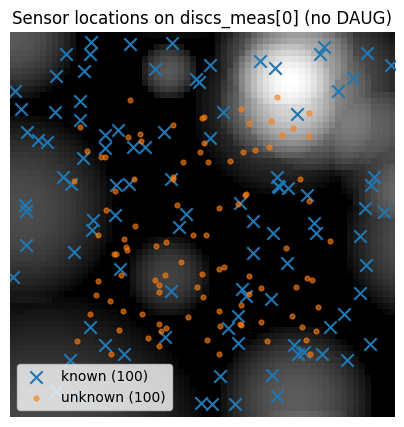

In [ ]:
# Définition du problème
torch.manual_seed(0)

H = W = 64
N0 = 100 # nb de couples de coordonnées connues
N1 = 100 #nb de couples de coordonnées inconnues

# coordonnées connues :
margin = 0
torch.manual_seed(0)
known_coordinates = torch.stack([
    margin + torch.rand(N0, dtype=torch.float32) * (W - 1 - 2*margin),
    margin + torch.rand(N0, dtype=torch.float32) * (H - 1 - 2*margin),
], dim=1).contiguous()
# coordonnées inconnues : (inutilsables à l'entraînement)
margin = 10
unknown_coordinates = torch.stack([
    margin + torch.rand(N1, dtype=torch.float32) * (W - 1 - 2*margin),
    margin + torch.rand(N1, dtype=torch.float32) * (H - 1 - 2*margin),
], dim=1).contiguous()


ds = DatasetPB1(
    bs=8,
    known_coordinates=known_coordinates,
    unknown_coordinates=unknown_coordinates,
    steps_per_epoch=5,
    device="cpu",
)

batch = next(iter(ds))
# --- Overlay sensor locations on one measurement disc (sanity) ---
disc0 = batch["discs_gt"][0, 0].numpy()

plt.figure(figsize=(5,5))
plt.imshow(disc0, cmap="gray")
plt.scatter(known_coordinates[:,0].numpy(), known_coordinates[:,1].numpy(),
            s=80, marker="x", label="known (100)")
idx = torch.randperm(N1)[:200]
plt.scatter(unknown_coordinates[idx,0].numpy(), unknown_coordinates[idx,1].numpy(),
            s=12, alpha=0.6, label="unknown (100)")
plt.legend()
plt.title("Sensor locations on discs_meas[0] (no DAUG)")
plt.axis("off")
plt.show()

# Partie I : une première procédure d'apprentissage

Dans la cellule suivante sont codées deux fonctions qui font le lien entre une description par des mesures ponctuelles et un champ 2D. La première "gaussian_splat", prend en entrée des coordonnées et des mesures de capteurs puis construit dans un champ 2D de taille 64 x 64 comme une somme de noyaux gaussiens centrés sur les couples de coordonnées.\
La seconde, "project_field", prend en entrée un champ quelconque et des coordonnées, puis fournit les valeurs du champ aux coordonnées, en interpolant.


In [ ]:
def gaussian_splat(meas_vals, coords_norm, H=64, W=64, sigma=2.0, radius=None, eps=1e-6):
    """
    meas_vals:  (B,N,1)  values
    coords_norm:(B,N,2)  normalized coords in [-1,1] (x,y)
    sigma: Gaussian std in *pixels*
    radius: kernel radius in pixels (default = ceil(3*sigma))
    Returns:
      img : (B,1,H,W)  normalized splat (value / weight)
      wsum: (B,1,H,W)  accumulated weights
    """
    B, N, _ = meas_vals.shape
    device = meas_vals.device
    dtype  = meas_vals.dtype

    if radius is None:
        radius = int(torch.ceil(torch.tensor(3.0 * sigma)).item())

    # normalized [-1,1] -> pixel [0,W-1]/[0,H-1]
    x = (coords_norm[..., 0] + 1.0) * (W - 1) / 2.0
    y = (coords_norm[..., 1] + 1.0) * (H - 1) / 2.0

    # keep finite; gradients outside can be weak anyway
    x = x.clamp(-1e6, 1e6)
    y = y.clamp(-1e6, 1e6)

    x0 = torch.floor(x).long()
    y0 = torch.floor(y).long()

    v = meas_vals[..., 0]  # (B,N)

    img  = torch.zeros(B, H*W, device=device, dtype=dtype)
    wsum = torch.zeros(B, H*W, device=device, dtype=dtype)

    # offsets in a (2r+1)x(2r+1) window
    offs = torch.arange(-radius, radius + 1, device=device)
    oy, ox = torch.meshgrid(offs, offs, indexing="ij")  # (K,K)
    ox = ox.reshape(-1)  # (K2,)
    oy = oy.reshape(-1)  # (K2,)
    K2 = ox.numel()

    # neighbor pixel indices for each point
    ix = x0.unsqueeze(-1) + ox.view(1, 1, K2)  # (B,N,K2)
    iy = y0.unsqueeze(-1) + oy.view(1, 1, K2)  # (B,N,K2)

    # distances (in pixels) to neighbor centers
    dx = x.unsqueeze(-1) - ix.to(dtype)  # (B,N,K2)
    dy = y.unsqueeze(-1) - iy.to(dtype)  # (B,N,K2)

    w = torch.exp(-(dx*dx + dy*dy) / (2.0 * (sigma**2)))  # (B,N,K2)

    # mask out-of-bounds neighbors
    inb = (ix >= 0) & (ix < W) & (iy >= 0) & (iy < H)
    w = w * inb.to(dtype)

    # flatten everything for scatter_add
    idx = (iy.clamp(0, H-1) * W + ix.clamp(0, W-1)).reshape(B, -1)  # (B, N*K2)
    w_flat = w.reshape(B, -1)                                       # (B, N*K2)
    v_flat = (v.unsqueeze(-1) * w).reshape(B, -1)                   # (B, N*K2)

    img.scatter_add_(1, idx, v_flat)
    wsum.scatter_add_(1, idx, w_flat)

    img  = img.view(B, 1, H, W)
    wsum = wsum.view(B, 1, H, W)
    img  = img / (wsum + eps)

    return img, wsum


def project_field(field, coords_norm):
    """
    field: (B,1,64,64)
    coords_norm: (B,N,2)
    """
    B = field.size(0)
    grid = coords_norm.view(B, 1, -1, 2)
    y = F.grid_sample(field, grid, align_corners=True, padding_mode="zeros")
    return y.squeeze(1).squeeze(1)  # (B,N)

**Q1** En quelques lignes de code :
- construire un champ 2D à partir de coordonnées/valeurs et représentez-le.
- justifier que torch parvient effectivement à calculer des gradients à travers ces fonctions.

Dans la cellule suivante est précodée l'architecture de base, qui, à partir de valeurs mesurées par les deux-cents capteurs et des coordonnées connues sera susceptible de fournir un champ 2D candidat :

In [ ]:
# ---- Generator: splat + 1 noise channel -> full UNet ----
class Generator(nn.Module):
    def __init__(self, N0, N1, d_model=64, n_heads=4, n_blocks=4,):
        super().__init__()
        self.N0 = N0
        self.N1 = N1
        self.N  = N0 + N1

        # ---- trainable unknown coordinates (normalized) ----
        self.unknown_coords = nn.Parameter(torch.empty(N1, 2).uniform_(-0.5, 0.5))

        # ---- UNet on (splat, noise) ----
        self.noise_alpha = 0.5
        self.unet = UNet64(in_ch=1, base=32, out_ch=1)

    def forward(self, meas_vals, known_coords_norm, sigma=2):
        """
        meas_vals: (B, N, 1) with -0.1 padding
        known_coords_norm: (N0,2) normalized
        mask(optional): (B,N,1) 1 present, 0 missing (if you want +0.1*mask trick)
        """
        B = meas_vals.size(0)
        device = meas_vals.device

        coords = torch.cat([
            known_coords_norm.unsqueeze(0).expand(B, -1, -1),
            self.unknown_coords.unsqueeze(0).expand(B, -1, -1)
        ], dim=1)  # (B,N,2)


        [A COMPLETER]

        return 2*torch.tanh(field) # application de tanh pour restreindre l'intervalle de sortie

**Q2** Compléter le code en faisant se suivre le splatting et l'application du UNet. Vérifier sur un exemple que le code est bien fonctionnel.

**Q3** Où sont les différents paramètres entraînables du générateur ? Préciser leur nombre pour chacun des attributs.

Dans la cellule suivante, on donne une amorce de boucle d'entraînement.
L'idée est de séparer chacun des batchs de 200 mesures mis à disposition, en un sous-ensemble de mesure d'entrée (proportion p_in) et un sous-ensemble de mesure cibles (proportion 1-p_in).

In [ ]:
ds = DatasetPB1(bs=32,
            known_coordinates=known_coordinates,
            unknown_coordinates=unknown_coordinates,
            steps_per_epoch=50,
            device=device)

for epoch in range(nepochs):
    # running sums for this epoch
    sum_l2 = 0.0
    sum_g  = 0.0
    sum_d  = 0.0
    n_steps = 0

    # Pas de DataLoader : on sollicite seulement le Dataset ds
    for batch in ds:
        # Récupération de l'ensemble des mesures disponibles
        meas = torch.cat([batch["meas_known"], batch["meas_unknown"]], dim=2)
        meas = meas[:,1,:].unsqueeze(-1).to(device)  # (B,N,1)

        # Masquage d'une partie des inputs (attention à la confusion valeurs nulles / valeurs masquées !)
        input_mask = (torch.rand_like(meas) < p_in).float()
        ...

        # Forward
        field = G(meas_in_shift, known_coords_norm, sigma)

        # Récupération des coordonnées normalisées
        coords_full = torch.cat([
            known_coords_norm.unsqueeze(0).expand(field.size(0), -1, -1),
            G.unknown_coords.unsqueeze(0).expand(field.size(0), -1, -1)
        ], dim=1)

        # PRojection
        ... = project_field(...)

        # Masque pour les cibles
        target_mask = ...

        # Optim
        loss_l2 = ...

        ...

    # Visualisation / Scoring (pas de validation)
    with torch.no_grad():
      if epoch % 10 == 0:
        viz_coords_pairs(
            unknown_coordinates=unknown_coordinates,
            unknown_coords_pred_norm=G.unknown_coords,
            N_viz=20,
            H=64, W=64
        )
        show_real_fake_grids(real=batch["discs_gan"], fake=field, n=16, title_suffix=f"(epoch {epoch})")

        if (epoch + 1) % 2 == 0:

          ...

**Q4** Compléter la boucle en suivant en tenant compte des éléments suivants :
- les valeurs sont toujours positives ou nulles. Il convient d'aider le générateur à bien différencier les valeurs nulles mesurées des valeurs qui sont masquées. Proposer une méthode qui le permette.

- à la fin de la boucle, afficher, en plus de la loss l2,  la distance médiane et le maximum des distances entre coordonnées vraies et coordonnées "prédites" pour les cents derniers points.

- afficher aussi la MAE entre le champ produit par le générateur et le champ à reconstituer.

**Q5** Pourquoi s'est-on passé de DataLoader et d'étape de validation dans cette boucle ?  

**Q6** Instancier le modèle, régler self.unknown_coords sur les vraies coordonnées inconnues (i.e. tricher) et geler ce paramètre. Entraîner sur 100 époques pour vérifier que dans ce cas, on a convergence progressive de la loss l2 sur les valeurs, mais pas de la MAE globale. Expliquer pourquoi.

**Q7** Maintenant, reprendre l'entraînement sans tricher ni geler le tenseur self.unknown_coords. Le modèle parvient-il a apprendre les bonnes coordonnées ? Pour quelles raisons à votre avis ?

**Q8** Pour espérer voir un début de convergence, il faut régler finement la procédure d'apprentissage. Ré-essayer avec les hyperparamètres ci-dessous,  et commentez :
- le choix du learning rate pour G.unknown_coords
- la réduction de p_in
- l'augmentation de sigma


In [ ]:
G = Generator(N0, N1).to(device)

optG = torch.optim.Adam([
    {"params": [G.unknown_coords], "lr": 0.025, "betas": (0.1, 0.1)},
    {"params": [p for n,p in G.named_parameters() if n != "unknown_coords"], "lr": 2e-4},
], betas=(0.5, 0.9))

p_in = 0.3
sigma = 4

**Q9** Un autre problème important tient à la divergence des paramètres. Ajouter la fonction de coût suivante, ré-entraînez, et commenter.

In [ ]:
def coord_hinge_loss(coords):
    return (
        F.relu(coords - 0.8).mean() +
        F.relu(-coords - 0.8).mean()
    )

**Q10** Parvenez-vous à réduire la distance max ? Faire plusieurs essais en retouchant éventuellement vos hyperparamètres pour passer sous 5 pixels (au moins pour la distance médiane). Gardez en mémoire la série temporelle des scores de votre meilleur version pour comparaison ultérieure (partie III).

**Q11** Conclure sur cette première version. En dehors de la piste qui sera suivie dans les parties suivantes, que feriez-vous pour l'améliorer ?

# Partie II

Dans cette partie, on essaie seulement d'implémenter un GAN à partir de batch['discs_gan'] et du générateur codé dans la partie I.
Les consignes sont les suivantes.

- Modifier le générateur : créer un bruit blanc gaussien à l'intérieur de la fonction forward, le placer en entrée du UNet à la place de la sortie du splatting.
- Créer un discriminateur. Vous pourrez reprendre l'architecture vue au TP n°6.
- Créer une boucle d'apprentissage. Reprendre les étapes standards du GAN (passer le discriminateur sur la sortie du générateur et sur batch['discs_gan'] alternativement en vous inspirant du TP n°6).
- Parvenir ainsi, en quelques dizaines d'époques à simuler des champs 2D proches de la réalité.
- Vérifier quantitativement en comparant les statistiques d'ordre 1 et 2 à l'échelle du pixel.

# Partie III

Dans cette partie, il s'agit de combiner les deux approches :
- Modifier simplement le UNet interne au générateur pour qu'il puisse prendre à la fois la sortie du splatting et le bruit gaussien.
- Modifier le discriminateur de façon à ce qu'il puisse avoir accès, en entrée, aux positions de tous les capteurs.
- Trouver une combinaison linéaire des trois fonctions de coût qui entraîne le générateur à évoluer suivant les deux contraintes (en reconstruction et contrainte GAN).
- Comparer avec les scores obtenus à la partie I.